In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
calendar_path = os.path.join(os.getcwd(), 'data', 'calendar.csv')
trainDF_path = os.path.join(os.getcwd(), 'data', 'sales_train_validation.csv')
pricesDF_path = os.path.join(os.getcwd(), 'data', 'sell_prices.csv')

df = pd.read_csv(trainDF_path)
calendarDF = pd.read_csv(calendar_path)
# pricesDF = pd.read_csv(pricesDF_path)

In [3]:

# renaming d_### format to actual dates
df = df.rename(columns=dict(zip(calendarDF.d.tolist(), pd.to_datetime(calendarDF.date).tolist())))



In [4]:
testCutOff = 30 #days removed for test set

dateStart = 1580 #pick something between 1 and 1913-testCutOff

prodIndex = 2435

dfNoLabels = df.iloc[:,6+dateStart:]

# train, test = npNorm[prodIndex,:npNorm.shape[1]-testCutOff], npNorm[prodIndex,npNorm.shape[1]-testCutOff:]
train = dfNoLabels.iloc[prodIndex,:-testCutOff]
test = dfNoLabels.iloc[prodIndex,-testCutOff:]

train.index = pd.to_datetime(dfNoLabels.iloc[prodIndex,:-testCutOff].index)
test.index = pd.to_datetime(dfNoLabels.iloc[prodIndex,-testCutOff:].index)

In [5]:
# function for best parameter search

def find_best_sarima(train, eval_metric):
    
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

    # p — the number of autoregressive
    # d — degree of differencing
    # q — the number of moving average terms
    # m — refers to the number of periods in each season
    # (P, D, Q )— represents the (p,d,q) for the seasonal part of the time series

    counter = 0
    myDict = {}
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                counter += 1
                mod = sm.tsa.statespace.SARIMAX(train,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                myDict[counter] = [results.aic, results.bic, param, param_seasonal]

                print('ARIMA{}x{}12 - AIC:{} - BIC:{}'.format(param, 
                                                param_seasonal, 
                                                results.aic, 
                                                results.bic))

            except:
                continue
                
    dict_to_df = pd.DataFrame.from_dict(myDict,orient='index')
    
    if eval_metric == 'aic':
        best_run = dict_to_df[dict_to_df[0] == dict_to_df[0].min()].index.values
        best_run = best_run[0]
    elif eval_metric == 'bic':
        best_run = dict_to_df[dict_to_df[1] == dict_to_df[1].min()].index.values
        best_run = best_run[0]
            
    model = sm.tsa.statespace.SARIMAX(train,
                                      order=myDict[best_run][2],
                                      seasonal_order=myDict[best_run][3],
                                      enforce_stationarity=False,
                                      enforce_invertibility=False).fit()
    
    best_model = {'model':model, 
                  'aic':model.aic,
                  'bic':model.bic,
                  'order':myDict[best_run][2], 
                  'seasonal_order':myDict[best_run][3]}
    
    return best_model

In [6]:
# run search to find best SARIMA parameters

best = find_best_sarima(train, 'aic')


80312245702 - BIC:1075.4939820894892
ARIMA(1, 2, 2)x(2, 0, 1, 7)12 - AIC:1055.9756797046807 - BIC:1081.5676223804196
ARIMA(1, 2, 2)x(2, 0, 2, 7)12 - AIC:1048.916385142139 - BIC:1078.1081790474286
ARIMA(1, 2, 2)x(2, 1, 0, 7)12 - AIC:1078.6383408470906 - BIC:1100.4256115380188
ARIMA(1, 2, 2)x(2, 1, 1, 7)12 - AIC:1035.1503953440965 - BIC:1060.568877816846
ARIMA(1, 2, 2)x(2, 1, 2, 7)12 - AIC:1022.0341086143243 - BIC:1051.026248663823
ARIMA(1, 2, 2)x(2, 2, 0, 7)12 - AIC:1207.7803866592233 - BIC:1229.4151990569992
ARIMA(1, 2, 2)x(2, 2, 1, 7)12 - AIC:1089.7632707093703 - BIC:1115.0038851734423
ARIMA(1, 2, 2)x(2, 2, 2, 7)12 - AIC:1088.9655172913035 - BIC:1117.7528929632906
ARIMA(2, 0, 0)x(0, 0, 0, 7)12 - AIC:1206.416658994821 - BIC:1217.5379897890678
ARIMA(2, 0, 0)x(0, 0, 1, 7)12 - AIC:1166.1831970679116 - BIC:1180.9310984932708
ARIMA(2, 0, 0)x(0, 0, 2, 7)12 - AIC:1119.5926980092663 - BIC:1137.9075004099461
ARIMA(2, 0, 0)x(0, 1, 0, 7)12 - AIC:1205.433016492682 - BIC:1216.4837557946983
ARIMA(2,

In [7]:
# predictions for next time step
pred = best['model'].predict(start=test.index[0], end=test.index[-1], dynamic=True)

best

{'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1baadaa6828>,
 'aic': 1008.8909206589093,
 'bic': 1030.6781913498376,
 'order': (0, 0, 2),
 'seasonal_order': (1, 1, 2, 7)}

In [24]:
param = (5, 3, 5)                # (p, d, q)
param_seasonal = (5, 3, 14, 7)   # (p, d, q, m)

# p — the number of autoregressive
# d — degree of differencing
# q — the number of moving average terms
# m — refers to the number of periods in each season
# (P, D, Q )— represents the (p,d,q) for the seasonal part of the time series

mod = sm.tsa.statespace.SARIMAX(train,
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

pred2 = results.predict(start=test.index[0], end=test.index[-1], dynamic=True)

print(results.aic)


816.7547966619923


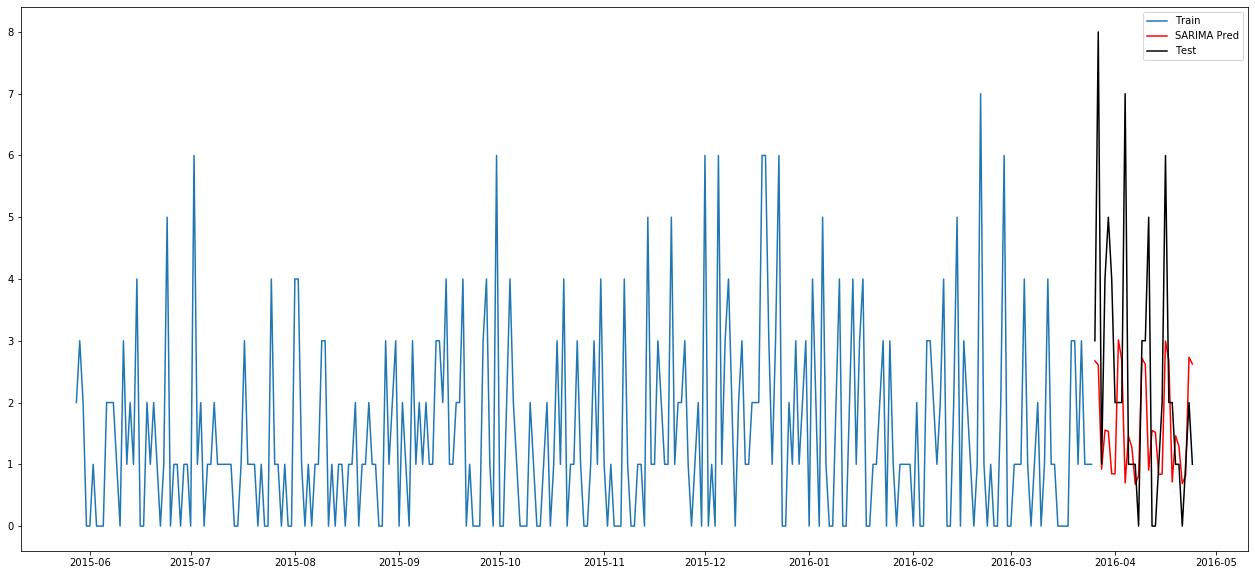

In [25]:

plt.figure(figsize=(22, 10))

plt.plot(train.index, train, label='Train')
# plt.plot(pred.index, pred, label='SARIMA Pred', color='r')      # auto generated parameters
plt.plot(pred2.index, pred, label='SARIMA Pred', color='r')     # hand selected parameters
plt.plot(test.index, test, label='Test', color='k')

plt.legend(loc='best')
plt.show()